In [1]:
import sys
import time
import numpy as np
import numba as nb
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PathWindows = r"D:\Учеба\Практика\Диплом\gamma"
LibraryPathWindows = r"D:\Учеба\Практика\Диплом\gamma\SpectrumsMeasurementsLibrary"
LibraryPathLinux = r"/home/danis/work/python_works/gamma"
sys.path.insert(0, LibraryPathWindows)
sys.path.insert(0, PathWindows)
sys.path.insert(0, LibraryPathLinux)

In [3]:
from GammaRayInteractions.Materials import Material, R
from CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices, open_detector
from NumericalMethods.simpson_rule import simpson_rule
from NumericalMethods.unfolding_technique import Gold

import matplotlib.ticker as mticker
from local_scripts import initialization_brem, generate_empty_matrix, complete_empty_matrix, integrate_the_row, get_integral_signals, apply_function_to_matrix, get_brem_measuring_results

Инициализация энергетического спектра

In [10]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

In [11]:
font_properties = {'family' : 'Arial', 'weight' : 'regular', 'size' : 16}
rc('font', **font_properties)

Создание энергетических спектров

In [12]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

# список энергий пучков электронов
beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)
beams_energyes = np.array(beams_energyes)

In [13]:
# зарядовые числа материалов мишеней
z_numbers = np.array([10*i for i in range(1,10)])

Создание трехмерной матрицы спектров

In [14]:
# создание матрицы со всеми сгенерированными спектрами
empty_bremsstrahlungs_matrix = generate_empty_matrix(len(z_numbers), len(beams_energyes))
bremsstrahlungs = complete_empty_matrix(empty_bremsstrahlungs_matrix, z_numbers, beams_energyes, initialization_brem)

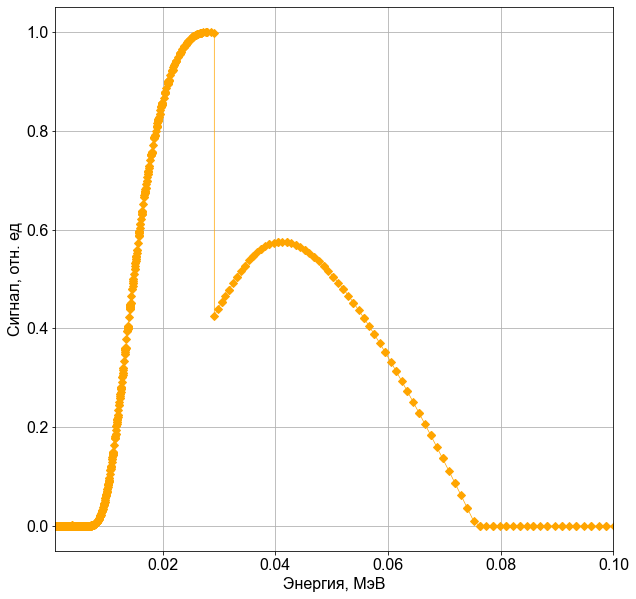

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ENERGY_MESH, bremsstrahlungs[4][15], ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

In [16]:
brem = bremsstrahlungs[4][15]

Создание списка с уровнями пропускания

In [17]:
levels = np.linspace(0.01, 0.9, 51)

Инициализация измерительных каналов

In [18]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel + 1

In [19]:
# создание систем с различными уровнями пропускания
MEASURING_SYSTEMS = []

for level in levels:
    system = [ross_method_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]
    system.insert(0, open_detector())
    
    MEASURING_SYSTEMS.append(system)

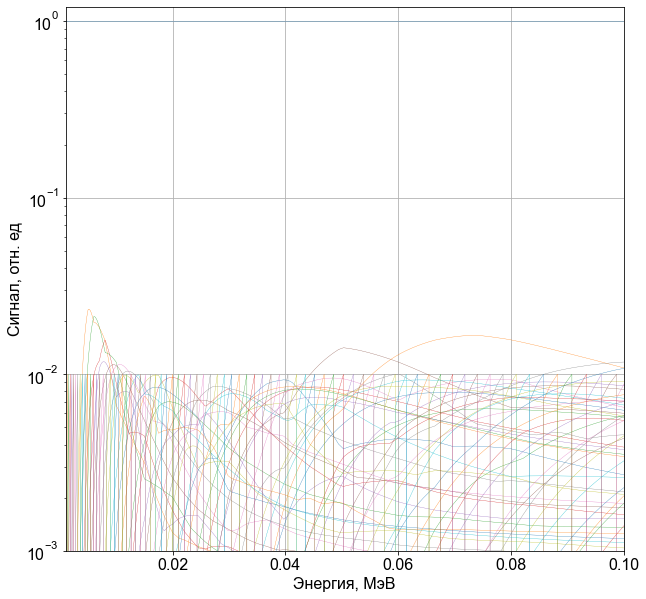

In [20]:
number_of_signals = fig, ax = plt.subplots(figsize=(10, 10))
for i in MEASURING_SYSTEMS[0]:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.3', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
ax.set_ylim(1e-3, 1.2)
ax.grid(True)

Создание матрицы с результатами измерения каждого спектра

In [21]:
empty_integral_signals_matrix = generate_empty_matrix(len(z_numbers), len(beams_energyes))

In [22]:
SYSTEMS_SIGNALS = [get_integral_signals(brem, measuring_system) for measuring_system in MEASURING_SYSTEMS]

In [23]:
# вычисление среднего значение энергии в полосах пропускания измерительных каналов
left_bounds = [Material(i).k_edge_energy() for i in range(11, 100)]
right_bounds = [val for val in left_bounds]
mean_energy_in_pass_band = (np.array(right_bounds) + np.array(left_bounds)) / 2

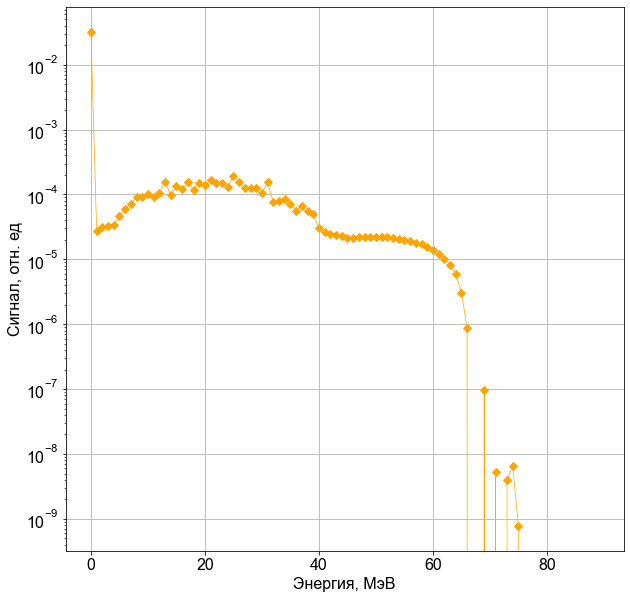

In [25]:
number_of_signals = len(SYSTEMS_SIGNALS[0])
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(number_of_signals), SYSTEMS_SIGNALS[1], ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

In [26]:
SYSTEMS_MATRIX = [np.array([simpson_rule(response, regime='c', function_jumps=[]) for response in MEASURING_SYSTEMS[level]])
                 for level in range(len(levels))]

Измерение каждого спектра каждой системой

In [27]:
empty = np.empty((len(z_numbers), len(beams_energyes)), dtype=object)
new_mesh_b = np.array(simpson_rule(MEASURING_SYSTEMS[0][0], regime='m', function_jumps=[]))

In [28]:
def get_measuring_systems_signals(brem, new_mesh, measuring_system_matrix):

    measuring_systems_signals = []
#     print(brem.shape)
#     print(new_mesh.shape)
    new_brem = np.interp(new_mesh, ENERGY_MESH, brem)
    for ind, matrix in enumerate(measuring_system_matrix):
        signals = matrix @ new_brem
        measuring_systems_signals.append(signals)

    return np.array(measuring_systems_signals)


def get_brem_measuring_results(bremsstrahlungs_matrix, measuring_system_matrix, new_mesh, empty):
    for row, val1 in enumerate(empty):
        for col, val2 in enumerate(empty[row]):
            empty[row][col] = get_measuring_systems_signals(bremsstrahlungs_matrix[row][col], new_mesh, measuring_system_matrix)

    return empty

In [29]:
BREMSSTRAHLUNGS_MEASURING_RESULTS = get_brem_measuring_results(bremsstrahlungs, SYSTEMS_MATRIX, new_mesh_b, empty)

Фильтрационные кривые

In [34]:
axis_channels, axis_energy = np.meshgrid([i for i in range(first_channel, last_channel+1)], beams_energyes)

In [35]:
RZ = BREMSSTRAHLUNGS_MEASURING_RESULTS[0,:]

In [47]:
z = 7
l = 5

In [48]:
R = [M[l,:] for M in BREMSSTRAHLUNGS_MEASURING_RESULTS[z,:]]
R = np.array(R)

Text(0.5, 0.92, 'Уровень: 0.9')

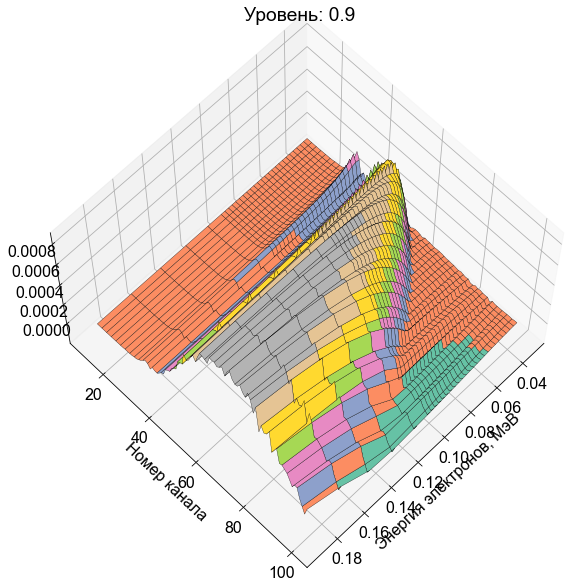

In [56]:

R = [M[l,:] for M in BREMSSTRAHLUNGS_MEASURING_RESULTS[z,:]]
R = np.array(R)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': '3d'})
ax.plot_surface(axis_energy[:30,1:], axis_channels[:30, 1:], R[:30,1:], cmap=cm.Set2, linewidth=0.3, edgecolors='k', shade=True)

ax.set_xlabel('Энергия электронов, МэВ')
ax.set_ylabel('Номер канала')
# ax.set_zlabel('Ср.кв. ошибка восстановления, отн. ед.')
fig.tight_layout()

# ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
# ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# угол зрения (логарифм)
ax.view_init(elev=65, azim=45)

titel = f'Уровень: {round(levels[l], 3)}'
ax.set_title(titel)

# fig.savefig(f'краевые_фильтры_Z{z_numbers[z]}_L{l}.jpg', bbox_inches='tight')

In [58]:
# for l in range(len(levels)):

#     R = [M[l,:] for M in BREMSSTRAHLUNGS_MEASURING_RESULTS[z,:]]
#     R = np.array(R)
#     fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': '3d'})
#     ax.plot_surface(axis_energy[:30,1:], axis_channels[:30, 1:], R[:30,1:], cmap=cm.Set2, linewidth=0.3, edgecolors='k', shade=True)

#     ax.set_xlabel('Энергия электронов, МэВ')
#     ax.set_ylabel('Номер канала')
#     # ax.set_zlabel('Ср.кв. ошибка восстановления, отн. ед.')
#     fig.tight_layout()

#     # ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#     # ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

#     # угол зрения (логарифм)
#     ax.view_init(elev=65, azim=45)

#     titel = f'Уровень: {round(levels[l], 3)}'
#     ax.set_title(titel)

#     fig.savefig(f'фильтры_Росса_Z{z_numbers[z]}_L{l}.jpg', bbox_inches='tight')

Восстановление спектра

In [32]:
bound_100_kev = Material(100).k_edge_index()
new_mesh = np.array(simpson_rule(MEASURING_SYSTEMS[0][0], regime='m', function_jumps=[]))

In [34]:
result = Gold(SYSTEMS_MATRIX[15], SYSTEMS_SIGNALS[15], -1, ENERGY_MESH, new_mesh, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')

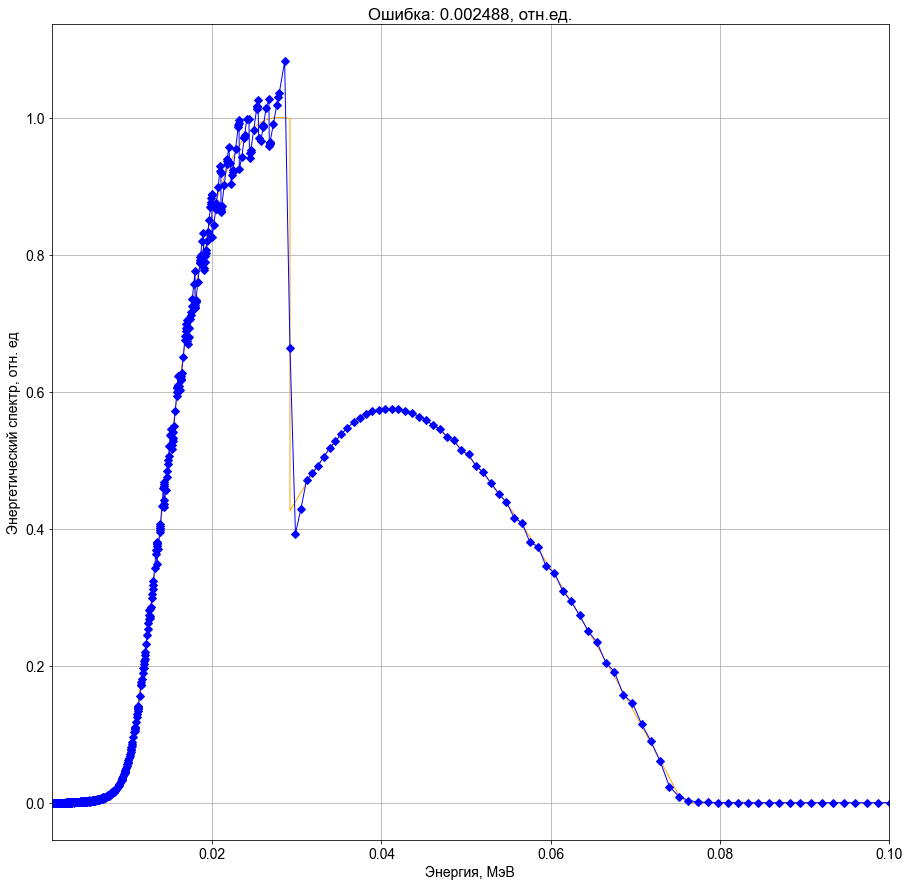

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.plot(ENERGY_MESH, brem, ls='-', lw='1', ms=5, color='orange')
ax.plot(new_mesh, result[0], ls='-', lw='1', marker='D', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.set_title(f'Ошибка: {round(result[1], 6)}, отн.ед.')

ax.grid(True)

# fig.savefig('Обусловленность матриц систем.jpg', bbox_inches='tight')

#

Сохранение результатов

In [79]:
np.save('ИЗМЕРИТЕЛЬНЫЕ СИСТЕМЫ Р.npy', MEASURING_SYSTEMS)

In [80]:
np.save('МАТРИЦЫ ИЗМЕРИТЕЛЬНЫХ СИСТЕМ Р.npy', SYSTEMS_MATRIX)

In [81]:
np.save('СИГНАЛЫ ИЗМЕРИТЕЛЬНЫХ СИСТЕМ Р.npy', SYSTEMS_SIGNALS)

In [83]:
np.save('УРОВНИ ПРОПУСКАНИЯ.npy', levels)

In [84]:
np.save('ЭНЕРГИИ ЭЛЕКТРОНОВ.npy', beams_energyes)